# Customer Clustering with KMeans to Boost Business Strategy
In this notebook it will be showned how to use the KMeans algorithm (unsupervised machine learning) to cluster customer data.


In [1]:
## Installing Required Libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D


### Exploring the data

In [2]:
#Loading the data in a csv file into a dataframe.
df_sst = pd.read_csv('Wholesale customers data.csv')

#First five rows is showned
df_sst.head(5)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
print(df_sst.columns)

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


In [4]:
#Showing the shape of the dataset.
df_sst.shape

(440, 8)

In [5]:
#Dropping columns 'Channel' and 'Region'
df_sst.drop(columns=['Channel', 'Region'], inplace= True)

### Preprocessing data using different scalers

In [6]:
# scale minimun and maximun
data_min_max = preprocessing.MinMaxScaler().fit_transform(df_sst)
data_min_max

array([[0.11294004, 0.13072723, 0.08146416, 0.0031063 , 0.0654272 ,
        0.02784731],
       [0.06289903, 0.13282409, 0.10309667, 0.02854842, 0.08058985,
        0.03698373],
       [0.05662161, 0.11918086, 0.08278992, 0.03911643, 0.08605232,
        0.16355861],
       ...,
       [0.1295431 , 0.21013575, 0.32594285, 0.00677142, 0.36346267,
        0.03888194],
       [0.091727  , 0.02622442, 0.02402535, 0.01664914, 0.00404174,
        0.04426366],
       [0.02482434, 0.02237109, 0.02702178, 0.00065742, 0.01161082,
        0.00102211]])

In [7]:
# Normalization of the data.
data_normalizer = preprocessing.Normalizer().transform(df_sst.T)
data_normalizer = data_normalizer.T
data_normalizer

array([[0.034663  , 0.04908746, 0.02911003, 0.00177727, 0.02290171,
        0.01991374],
       [0.0193083 , 0.04987034, 0.03683703, 0.01463339, 0.02820319,
        0.02643259],
       [0.01738212, 0.04477655, 0.02958358, 0.0199735 , 0.03011309,
        0.11674394],
       ...,
       [0.03975752, 0.07873515, 0.11643627, 0.00362928, 0.12710706,
        0.02778696],
       [0.02815394, 0.01007066, 0.00859325, 0.00862058, 0.00143885,
        0.03162683],
       [0.00762537, 0.00863199, 0.00966356, 0.00053982, 0.00408531,
        0.00077393]])

In [8]:
# Standard scaler
data_standard_scaler = preprocessing.StandardScaler().fit_transform(df_sst)
data_standard_scaler

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

In [9]:
data_robust_scaler = preprocessing.RobustScaler().fit_transform(df_sst)
data_robust_scaler

array([[ 0.30168043,  1.06571214,  0.32995207, -0.46657183,  0.50678671,
         0.2638102 ],
       [-0.1048095 ,  1.09293385,  0.56599336,  0.08392603,  0.67567015,
         0.5740085 ],
       [-0.15580183,  0.91581599,  0.34441798,  0.3125889 ,  0.73651183,
         4.87145892],
       ...,
       [ 0.43654933,  2.09660171,  2.99755961, -0.38726885,  3.826342  ,
         0.63845609],
       [ 0.12936404, -0.29095409, -0.29678633, -0.17354196, -0.176932  ,
         0.82117564],
       [-0.41409532, -0.34097839, -0.26409103, -0.51955903, -0.0926267 ,
        -0.64695467]])

### Plotting data

In [10]:

# Convert numpy array to DataFrames for plotting
#data_min_max = pd.Dataframe(data_min_max)
#data_normalizer = pd.Dataframe(data_)
#data_standard_scaler = pd.Dataframe(data_)
#data_robust_scaler = pd.Dataframe(data_)

### Creating a function for deciding which scaler is better according to the data distribution



In [14]:
df_sst.columns()

TypeError: 'Index' object is not callable

In [11]:
def analyze_scaling_needs(data=pd.DataFrame):
    # Convert to DataFrame if not already
    #df = pd.DataFrame(data) if not isinstance(data, pd.DataFrame) else data
    
    results = {}
    fig, axes = plt.subplots(len(data.columns), 3, figsize=(15, 5*len(data.columns)))
    
    for idx, column in enumerate(data.columns):
        values = data[column].values
        
    # 1. Checking outliers
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    outlier_bounds = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    outliers = np.sum((values < outlier_bounds[0]) | (values > outlier_bounds[1]))
    
    # 2. Test for normality
    _, normality_p_value = stats.normaltest(values)
    
    # 3. Check value range
    value_range = values.max() - values.min()
    
    # Visualizations
    # Histogram
    sns.histplot(data, x=column, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{column} Distribution')
    
    # Box plot
    sns.boxplot(data, x=column, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{column} Box Plot')
    
    # Q-Q plot
    stats.probplot(values, dist="norm", plot=axes[idx, 2])
    axes[idx, 2].set_title(f'{column} Q-Q Plot')
          
    # Storing analysis results
    results[column] = {
        'has_outliers': outliers > 0,
        'outlier_count': outliers,
        'is_normal': normality_p_value > 0.05,
        'value_range': value_range,
        'skewness': stats.skew(values)
    }
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print("\nScaling Recommendations:")
    print("-----------------------")
    for column in data.columns:
        print(f"\nColumn: {column}")
        r = results[column]
        
        if r['has_outliers'] and r['outlier_count'] > len(data.columns) * 0.01:
            print("✓ RobustScaler recommended due to significant outliers")
        
        if r['is_normal']:
            print("✓ StandardScaler suitable due to normal distribution")
        
        if r['value_range'] > 10:
            print("✓ MinMaxScaler could be useful for large value ranges")
            
        if abs(r['skewness']) > 2:
            print("✓ Consider log transformation before scaling")
    
    return results


In [12]:
# You can then apply the recommended scaler
# For example, if RobustScaler was recommended:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_sst)

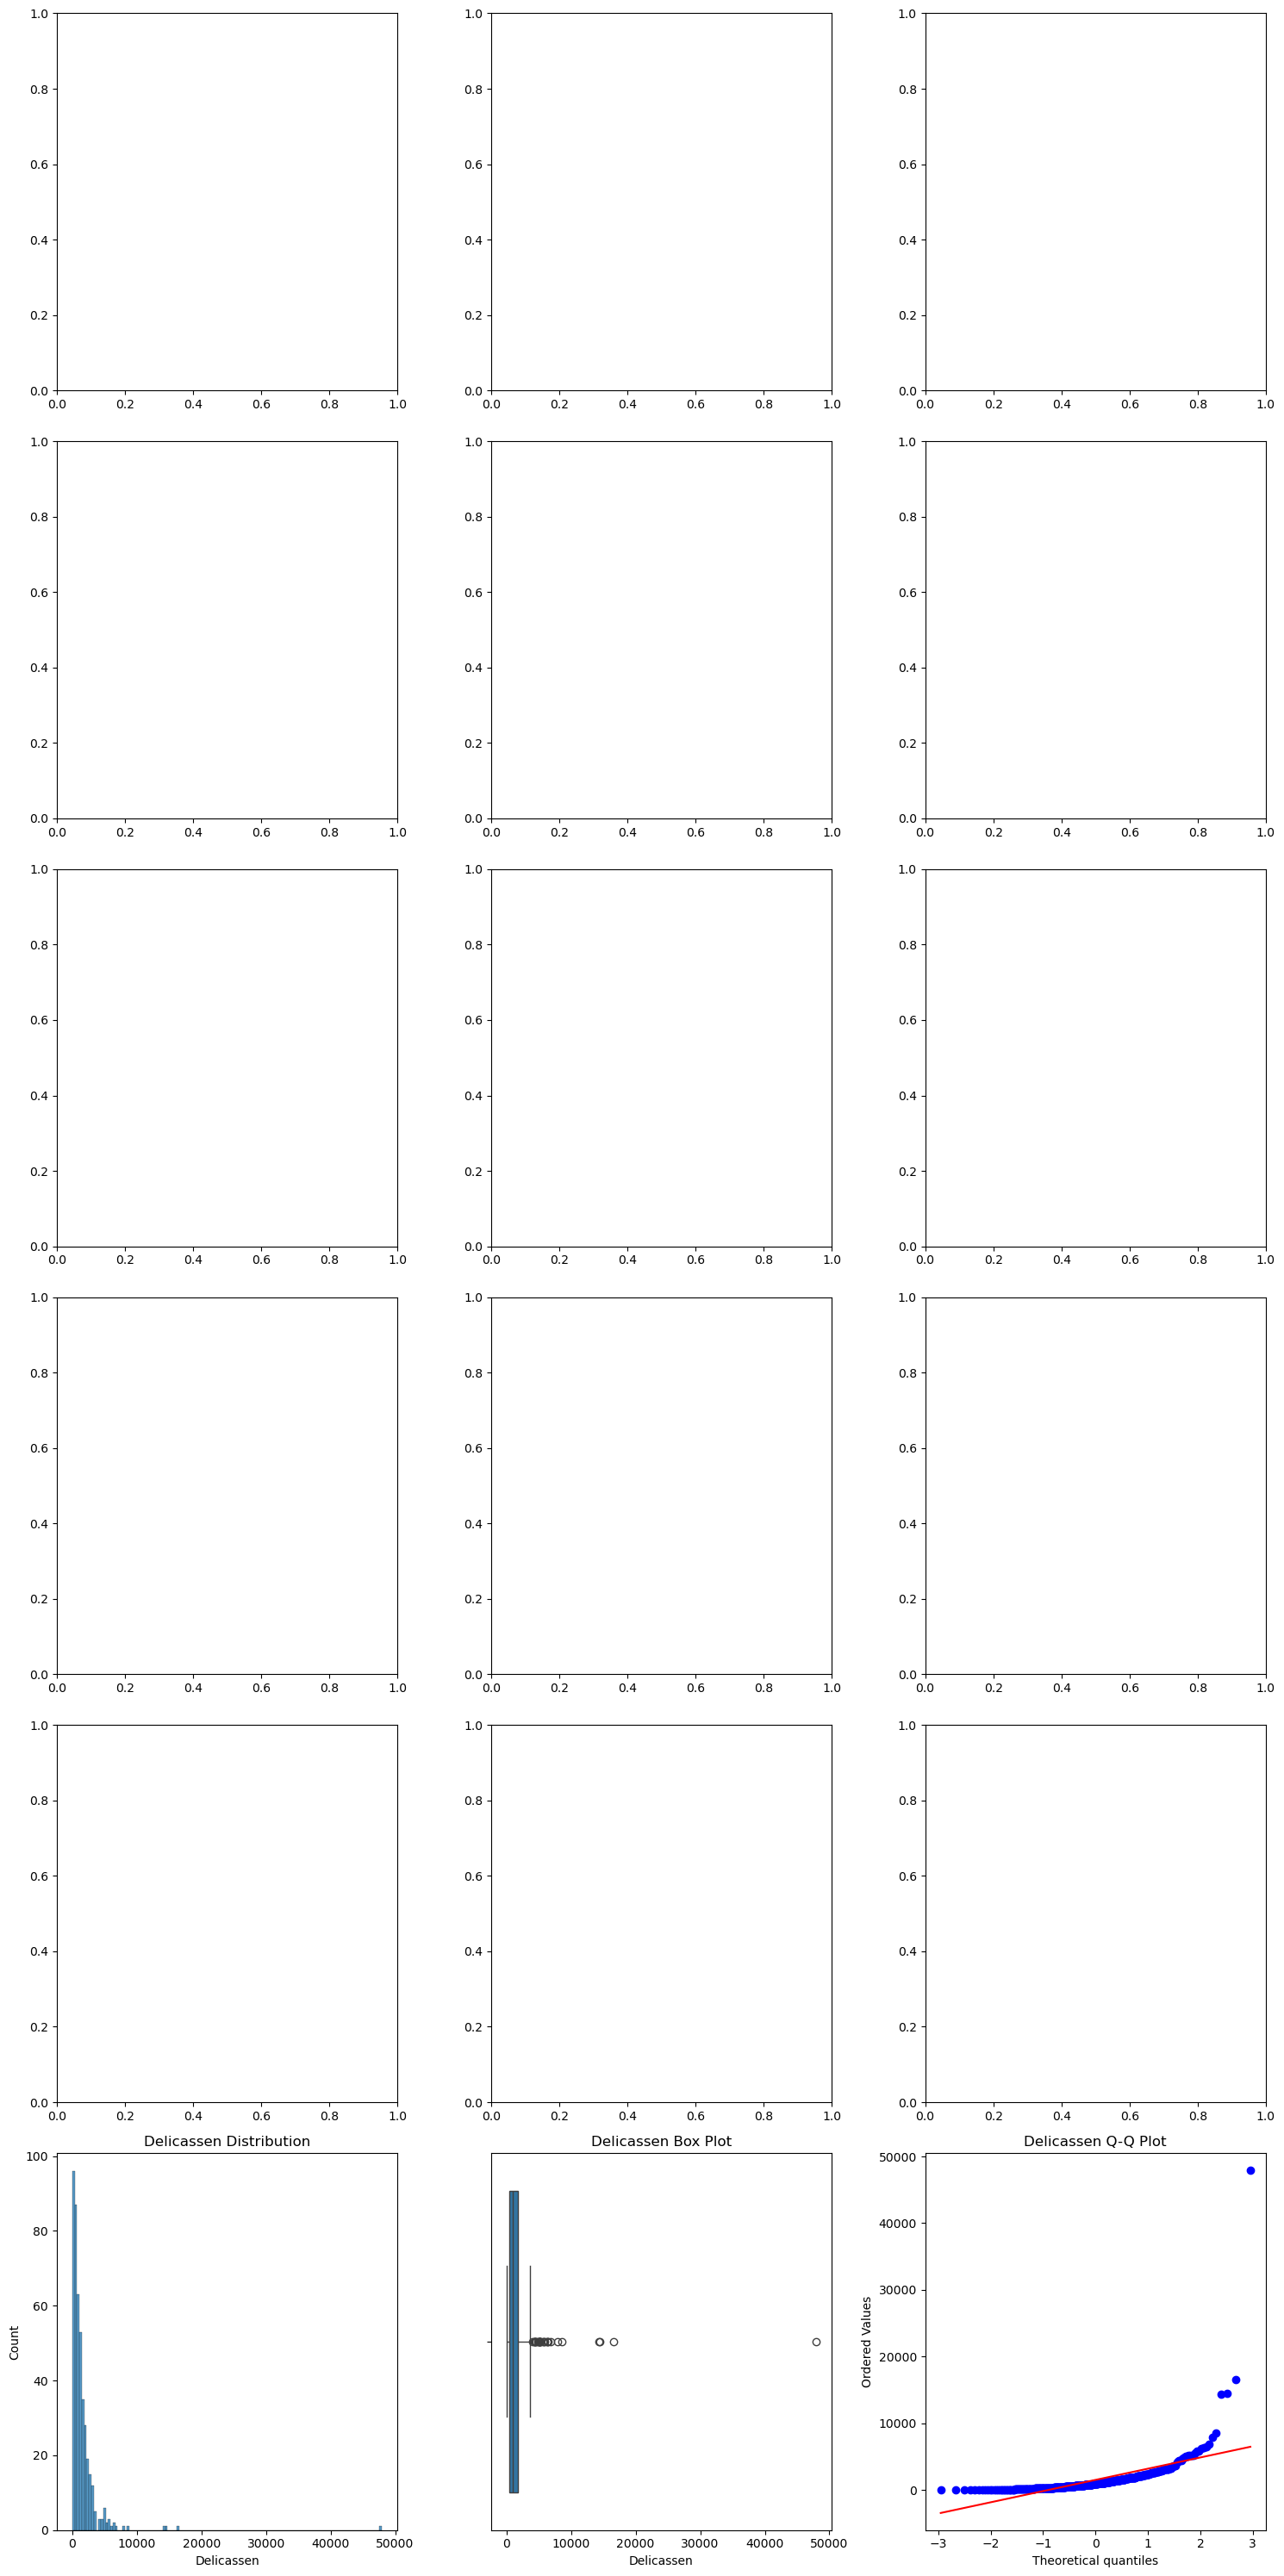


Scaling Recommendations:
-----------------------

Column: Fresh


KeyError: 'Fresh'

In [13]:
#columns_to_analyze = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
#results = analyze_scaling_needs(df_sst)
analyze_scaling_needs(df_sst)

In [ ]:
# Assuming df_sst is your DataFrame
#columns_to_analyze = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
#analyze_scaling_needs(df_sst)

### Deciding how many clusters to create using "Elbow method"

In [ ]:
# Standardize the features
scaler = RobustScaler()
# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_sst), columns=df_sst.columns)

# Calculate inertia for different numbers of clusters
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(2,10), inertia, marker="o", color="aquamarine")
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In conclution our k for the model is 4.

In [11]:
number_of_clusters = 4

In [12]:
#Create a KMeans clustering model.
cluster = KMeans(n_clusters = number_of_clusters)

#Determing the value of the parameter 'n_init' for future changes 
kmeans = KMeans(n_init='auto')

In [ ]:
#Training the model. 
result = cluster.fit_transform(df_sst)

In [ ]:
#Cluster centers are printed.
cluster.cluster_centers_

### Making Predictions

In [ ]:
#Ckecking columns name.
df_sst.columns.tolist()

In [ ]:
#Making predictions and saving them into the column "cluster_number".
df_sst['cluster_number'] = cluster.predict(df_sst)
df_sst.sample(5)

In [ ]:
#Printing the cluster numbers and the number of customers in each cluster.
df_sst.cluster_number.value_counts()

In [22]:
# Generate sample data for clustering
X, y = make_blobs(n_samples=440, 
                  centers=4, 
                  cluster_std=0.6, 
                  random_state=0)

In [ ]:
# Apply k-means clustering
cluster.fit(X)

In [ ]:
# Plotting the clusters and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_, cmap='viridis')
plt.scatter(cluster.cluster_centers_[:, 0], cluster.cluster_centers_[:, 1], marker='*', s=400, color='r')
plt.show()

In [ ]:
#Bonus: plotting cluster in 3D
X, y = make_blobs(n_samples=440,
                n_features= 3,
                 centers=4, 
                 cluster_std=0.1, 
                 random_state=42)

#Creating 3D scatter plot
fig = plt. figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

#Plotting the points
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2],
                     c=y,
                     cmap='viridis'
                     )

#Adding labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Clustering Visualization')

#Adding a color bar
plt.colorbar(scatter)

#Showing the plot
plt.show()
